In [1]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-05-31 22:41:14.150967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib is building the font cache; this may take a moment.


## Get the compressed data

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  12.3M      0  0:01:03  0:01:03 --:--:-- 15.9M 0  6930k      0  0:01:56  0:00:01  0:01:55 6946k 0:00:49 11.3M    0  0:01:08  0:00:35  0:00:33 14.7M


In [3]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

CDLA-Permissive-2.0.pdf              Untitled.ipynb
ImageClassificationFromScratch.ipynb kagglecatsanddogs_5340.zip
PetImages                            readme[1].txt


In [4]:
!ls PetImages

Cat Dog


## Filter out corrupt images

In [6]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


## Generate a Dataset

In [7]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset

2024-06-01 06:33:50.231053: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


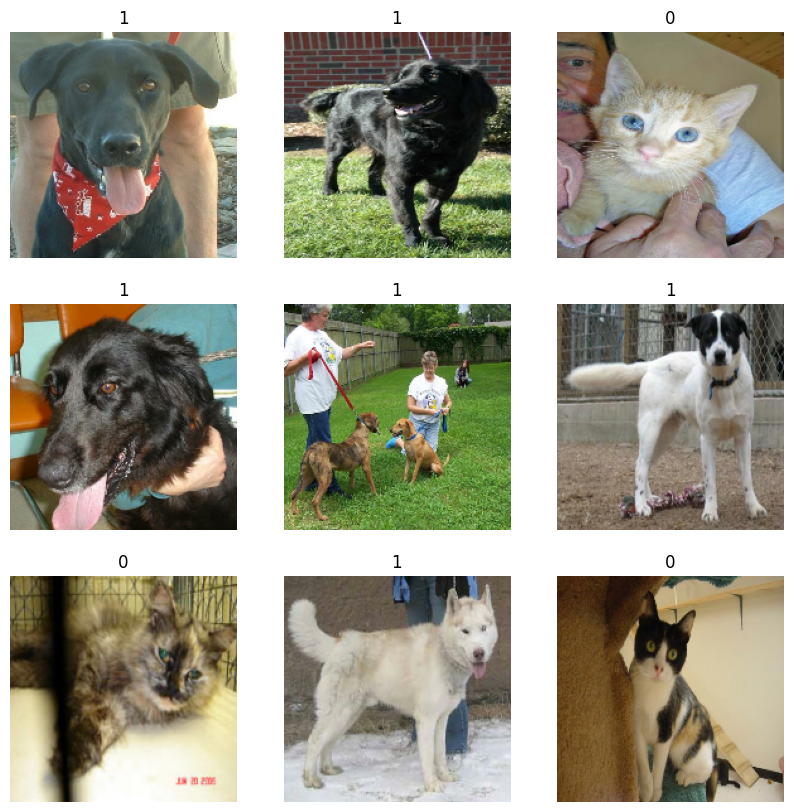

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis('off')

When there is not a large dataset, one way to introduce diversity is by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This will help exposing the model to different aspects of the training data while slowing down overfitting. 

In [9]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

Let's visualize what the augmented samples look like, by applying `data_augmentation` repeatedly to the first few images in the dataset:

2024-06-01 07:03:34.278926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


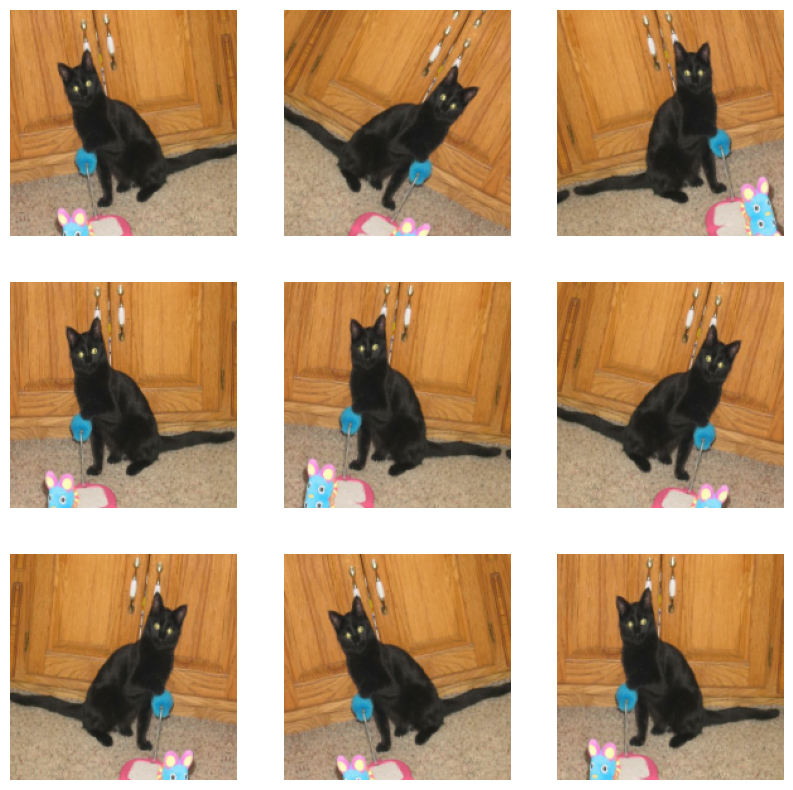

In [11]:
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

Standardizing the data
Our image are already in a standard size (180 x 180) as they are being yielded as contiguous `float32` batches by our dataset. However, their RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general NN BackProp and inference works best with small input values. So we will standardize the values to be in the range `[0, 1]` by using a `Rescaling` layer at the start of the constructed model.

## Two options to preprocess the data

### Option 1: Make it part of the model 

The following code illustrates this approach

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
... # rest of the model
```
With this option, the data augmentation will happen _on device_ , synchronously with the resot of the model execution, meaning that it will benefit from GPU acceleration.

Obviously, the input samples will only be augmented during `fit()`, not when calling `evaluate()` or `predict()`. Training on GPU will be substantially faster than relying on CPU.

### Option 2: apply it to the dataset

To obtain a dataset that yields batches of augmented images apply it to the dataset as shown below:

```python
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))
```
With this option, your data augmentation will happen on CPU, asynchronously, and will be buffered before going into the model.
Augmentation is asynchronous and non-blocking which is beneficial if relying on CPU. 


## Configure the dataset for performance

Let us apply data augmentation to our training dataset and use buffered prefetching so we can yield data from disk without becoming IO bound:

In [13]:
# apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Read the [following stackoverflow thread](https://stackoverflow.com/questions/29564759/history-saving-thread-error-when-trying-to-open-pandas) should you encounter the following runtime error

```
The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
```

## Build a model

We will build a small version of the Xception network. Optimization of the architecture is beyond the scope of this artcile. Systematic analysis of best model configuration can be performend by KerasTuner. 